In [724]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import re
from numpy.linalg import norm as norm

In [725]:
def get_data(path):
    array_ = []
    for directory in os.listdir(path):
        filepath = os.path.join(path,directory)
        with open(filepath,'r', errors='replace') as f: # to deal with uf8 error replaced errors
            observation = f.read()
            array_.append(observation)
    return np.array(array_)

In [726]:
base = "/Users/vashisth/Documents/GitHub/Fall_23/Intro_to_ML/homework3/hw3_data&code/hw3_data/"

path_train_ham = base + 'train/ham'
path_train_spam = base+ 'train/spam'
path_test_ham = base+ 'test/spam'
path_test_spam = base+ 'test/spam'

In [727]:
def get_data(path):
    array_ = []
    for directory in os.listdir(path):
        filepath = os.path.join(path,directory)
        with open(filepath,'r', errors='replace') as f: # to deal with uf8 error replaced errors
            observation = f.read()
            array_.append(observation)
    return np.array(array_)

In [728]:
X_train_ham_text = get_data(path_train_ham)
X_train_spam_text  = get_data(path_train_spam)

In [729]:
X_test_ham_text  = get_data(path_test_ham)
X_test_spam_text  = get_data(path_test_spam)

In [730]:
X_train = np.concatenate((X_train_ham_text, X_train_spam_text), axis=0)
X_test = np.concatenate((X_test_ham_text, X_test_spam_text), axis=0)
X_train.shape, X_test.shape


((463,), (260,))

In [731]:
y_train = np.concatenate((np.ones(X_train_ham_text.shape[0]), np.zeros(X_train_spam_text.shape[0])))
print(y_train.shape)

(463,)


In [732]:
with open("/Users/vashisth/Documents/GitHub/Fall_23/Intro_to_ML/homework3/hw3_data&code/hw3_data/dic.dat") as f:
    dict_list = f.read().splitlines() # bag of words list

In [733]:
bag_of_words = dict.fromkeys(dict_list, 0) # bag of words dict

### Make feature vectors and matrix

In [735]:
# (multiple delimiters): https://stackoverflow.com/questions/4998629/split-string-with-multiple-delimiters-in-python

def get_keyIndex(word, bow_d):
    key_list = list(bow_d.keys())
    getIndex = key_list.index(word)
    return getIndex


def bg_feature(textcol,bow_d):
    bg_feature = [0] * len(bow_d)
    tokenized = re.split(r'[,\?\s]+', textcol)
    # tokenized = tokenizer(textcol)
        
    for token in tokenized:
        if token in bow_d:
            bow_d[token] +=1
            index_tobe_updated = get_keyIndex(token, bow_d)
            bg_feature[index_tobe_updated] +=1
        else:
            continue
    return bg_feature, bow_d

In [736]:
def feature_matrix(textlist, bow_d):
    X = []
    for i in range(len(textlist)):
        text_i = textlist[i]
    
        feature_vec, updated_dict = bg_feature(text_i, bow_d)
        X.append(feature_vec)
        bow_d = updated_dict
        
    X = np.asarray(X)
    return X, bow_d

### Most Frequent Words

In [737]:
X_train_vec, bow_train = feature_matrix(X_train, bag_of_words.copy())
sorted_train =  sorted(bow_train.items(), key=lambda item: item[1], reverse=True)
print("Train set: {", "{},{},{}".format(sorted_train[0], sorted_train[1], sorted_train[2]), "}")

Train set: { ('enron', 600),('will', 351),('please', 291) }


In [738]:
X_train_ham_vec, bow_train_ham = feature_matrix(X_train_ham_text, bag_of_words.copy())
sorted_train_ham =  sorted(bow_train_ham.items(), key=lambda item: item[1], reverse=True)
print("Ham Train set: {", "{},{},{}".format(sorted_train_ham[0], sorted_train_ham[1], sorted_train_ham[2]), "}")

X_train_spam_vec, bow_train_spam = feature_matrix(X_train_spam_text, bag_of_words.copy())
sorted_train_spam =  sorted(bow_train_spam.items(), key=lambda item: item[1], reverse=True)
print("Spam Train set: {", "{},{},{}".format(sorted_train_spam[0], sorted_train_spam[1], sorted_train_spam[2]), "}")

Ham Train set: { ('enron', 600),('will', 310),('deal', 287) }
Spam Train set: { ('price', 65),('http', 60),('more', 44) }


## Q2

In [742]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [746]:
def loss_regularized(X, Y, w, bias, lambda_val, regularized):
    pred = sigmoid(X@w + bias)
    
    # bounding x by max(1e-16)
    #  and 1-x by limiting x = min(x, 1-1e-16)
    pred_bounded =  np.array([max(1e-16, min(x, 1-1e-16)) for x in pred])

    loss = Y * np.log(pred_bounded) + (1-Y) *(np.log(1- pred_bounded) )
    
    loss = -np.sum(loss)
    
    if regularized == True:
        regularizer = lambda_val * np.dot(w, w)
        loss += regularizer
    
    return loss


$$ \frac{\partial \epsilon(w, b)}{\partial w} = \sum_{i=1}^{n} \left( \sigma(b + w^\top x_i) - y_i \right) x_i + 2\lambda w $$

($2\lambda w$ is added only for the regularization term)
$$ \frac{\partial \epsilon(w, b)}{\partial b} = \sum_{i=1}^{n} \left( \sigma(b + w^\top x_i) - y_i \right)
$$


In [758]:
def gradients_regularized(X, Y, w, bias, lambda_val, regularized):

    pred = sigmoid(X@w + bias)
    err = pred - Y
    
    grad_w = X.T @ err
    
    if regularized is True:
        grad_w += 2 * lambda_val * w

    grad_b = np.sum(err)
    
    return grad_w, grad_b

In [748]:
def gradient_descent_run(X, Y, lambda_val, eta, regularized, iter = 50):
    n, features = X.shape
    loss_list, w_list, b_list = [], [], []
    w = np.zeros(features)
    b = 0.1
    
    for i in range(iter):
        grad_w, grad_b = gradients_regularized(X, Y, w, b, lambda_val,regularized=regularized)
        # get the loss
        loss = loss_regularized(X, Y, w, b, lambda_val, regularized=regularized)
        # new update
        w = w - eta * grad_w
        b = b - eta * grad_b
        # append
        loss_list.append(loss)
        w_list.append(w)
        b_list.append(b)
    
    w_norms = [norm(i) for i in w_list]

    return loss_list, w_list, b_list, w_norms

In [750]:
eta_list = [0.001, 0.01, 0.05, .1, .5] # lr list


loss_unreg, loss_reg = [], []
norm_list, norm_list_reg = [], []

for eta_i in eta_list:
    
    loss_list, w_list, b_list, w_norms = gradient_descent_run(X_train_vec, y_train,lambda_val =0, eta = eta_i, regularized=False, iter = 50)
    norm_list.append(norm(w_list[-1]))
    loss_unreg.append(loss_list)
    
    loss_list_reg, w_list_reg, b_list_reg, w_norms_reg = gradient_descent_run(X_train_vec, y_train,lambda_val =0.1, eta = eta_i, regularized=True, iter = 50)
    norm_list_reg.append(norm(w_list_reg[-1]))
    loss_reg.append(loss_list_reg)

/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_2104/3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


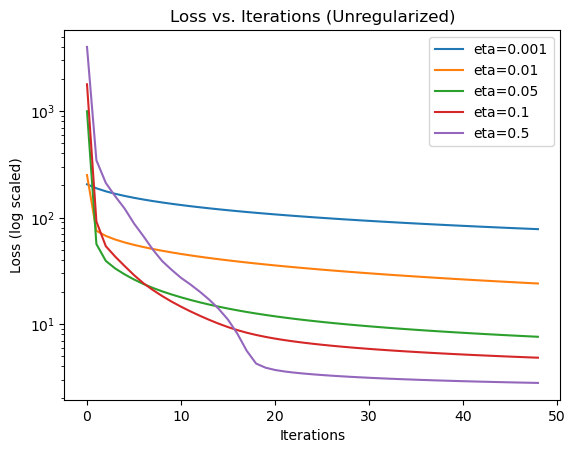

In [751]:
# Plotting the losses for unregularized runs
for i in range(len(eta_list)):
    plt.plot(loss_unreg[i][1:], label=f'eta={eta_list[i]}')
    
plt.title('Loss vs. Iterations (Unregularized)')
plt.xlabel('Iterations')
plt.yscale('log')
plt.ylabel('Loss (log scaled)')
plt.legend()
plt.savefig('lossplots_unreg')
plt.show()

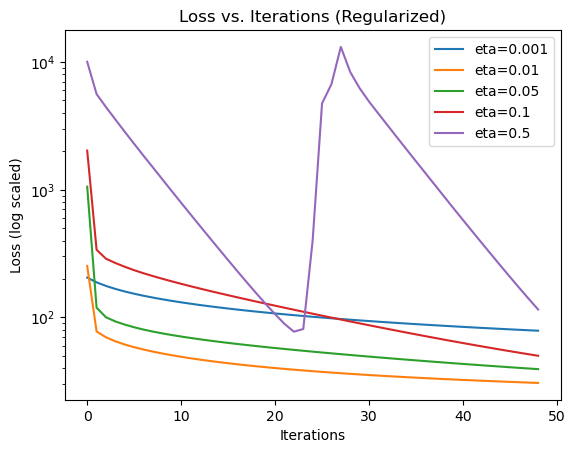

In [752]:
# Plotting the losses for regularized runs
for i in range(len(eta_list)):
    plt.plot(loss_reg[i][1:], label=f'eta={eta_list[i]}')
plt.title('Loss vs. Iterations (Regularized)')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scaled)')
plt.yscale('log')
plt.legend()
plt.savefig('lossplots_reg')
plt.show()

In [753]:
for i in range(len(eta_list)):
    print("Unreg: Norm {:.2f}, eta {}".format(float(norm_list[i]), eta_list[i]))


Unreg: Norm 2.57, eta 0.001
Unreg: Norm 7.71, eta 0.01
Unreg: Norm 26.17, eta 0.05
Unreg: Norm 50.73, eta 0.1
Unreg: Norm 250.65, eta 0.5


In [754]:
for i in range(len(eta_list)):
    print("Reg: Norm {:.2f}, eta {}".format(float(norm_list_reg[i]), eta_list[i]))

Reg: Norm 2.55, eta 0.001
Reg: Norm 7.26, eta 0.01
Reg: Norm 16.80, eta 0.05
Reg: Norm 19.95, eta 0.1
Reg: Norm 29.86, eta 0.5


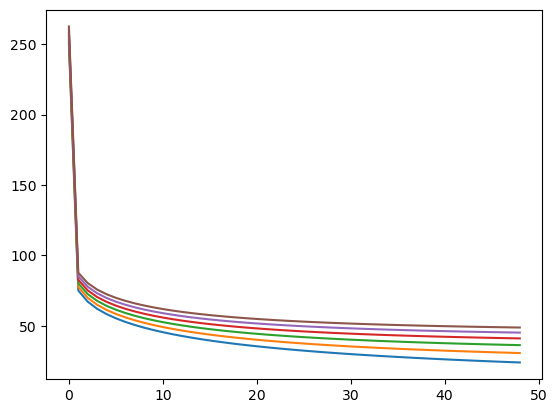

In [756]:
lambda_list = [0, .1, .2, .3, .4, .5]
    
loss_reg_lambda, norm_reg_lambda = [], []

# eta = .01 for all lambda
for  i in range(len(lambda_list) ):
    lambdas = lambda_list[i]
    loss_list_reg, w_list_reg, b_list_reg, w_norms_reg = gradient_descent_run(X_train_vec, y_train,lambda_val =lambdas, eta = .01, regularized=True, iter = 50)
    
    norm_reg_lambda.append(norm(w_list_reg[-1]))
    loss_reg_lambda.append(loss_list_reg)
    
    plt.plot(loss_reg_lambda[i][1:], label=f'eta={lambda_list[i]}')
    
# plt.title('Loss vs. Iterations (Unregularized)')
# plt.xlabel('Iterations')
# plt.yscale('log')
# plt.ylabel('Loss (log scaled)')
# plt.legend()
# plt.show()

In [757]:
for i in range(len(lambda_list)):
    print("Reg: Norm {:.2f}, lambda {}".format(float(norm_reg_lambda[i]), lambda_list[i]))

Reg: Norm 7.71, lambda 0
Reg: Norm 7.26, lambda 0.1
Reg: Norm 6.85, lambda 0.2
Reg: Norm 6.49, lambda 0.3
Reg: Norm 6.17, lambda 0.4
Reg: Norm 5.88, lambda 0.5
